# ノート 6: 複雑な分類問題への ML の適用

### 目標: 複数の特徴量/予測変数/入力変数を使って ML の学習を行う

### 問題設定

1. 各画像は雷雲を含んでいるか（分類問題）
2. 各画像にはいくつの発雷があるか（回帰問題）

### 背景

先にノート 4 の内容を学習しておいてください。
このノートではノート 4 で 1 変数を入力値として分類問題を ML で学習させた手法を複数の変数を入直値とした ML に適用し、評価、検証を行います。


### Step 1 & 2: パッケージのインポートとデータの読み込み

ノート 4 では 1 つの特徴量だけを使いましたが次は利用できるすべての特徴量（36 個の特徴量）を使いましょう。
ユーティリティ関数の `feature_to_keep` 引数を変更するだけです。


In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df

(X_train, y_train), (X_validate, y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 36, 1),  # 0-35番目までの全特徴量を読み込む
    class_labels=True,
)

読み込んだデータの形状を確認しましょう。サイズ `[n_samples, n_features]` の `X` と `[n_samples]` の`y`が読み込めているでしょうか。


In [2]:
print("X_train, y_train shapes: {},{}".format(X_train.shape, y_train.shape))
print("X_val, y_val shapes: {},{}".format(X_validate.shape, y_validate.shape))
print("X_test, y_test shapes: {},{}".format(X_test.shape, y_test.shape))

X_train, y_train shapes: (446307, 36),(446307,)
X_val, y_val shapes: (82871, 36),(82871,)
X_test, y_test shapes: (89716, 36),(89716,)


### Change from Notebook 4

複数の特徴量を用いるため正規化を行うことが重要になります。なぜ正規化が必要なのでしょうか？
各入力変数がとる値の幅はそれぞれ異なっており、大きな変動のある変数もあれば変化が小さい変数もあります。
ML は入力変数に対する重みを学習するため、正規化を行わない場合、変動幅が大きな入力変数が小さな変数に対して予測にバイアスを持つかもしれません。
こうした影響を避けるために、各入力変数を平均 0、分散 1 になるようにスケールします。
すなわち、訓練データセットから求めた平均 $\mu$ 、標準偏差 $\sigma$ のとき

$$ z=\frac{x-\mu}{\sigma} $$

と正規化します。この正規化は scikit-learn では前処理を行うクラスとして用意されていて
`sklearn.preprocessing.StandardScalar` をモデルの学習前に適用するだけです。


In [3]:
from sklearn.preprocessing import StandardScaler

# Scalarクラスを訓練データに適合させる
scaler = StandardScaler()
scaler.fit(X_train)

# transform メソッドで特徴量をスケール
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

# 平均と標準偏差を確認
np.mean(X_train, axis=0), np.std(X_train, axis=0)

(array([ 4.56472368e-16,  3.53052847e-16,  2.49633326e-17,  6.47008825e-17,
         2.03782307e-18,  6.24083316e-17,  2.36132748e-16, -2.13971423e-16,
        -1.21250473e-16, -7.13238075e-17,  3.44901555e-16,  2.64916999e-16,
         8.86962492e-16, -2.30834408e-15, -4.03361604e-16,  3.12551114e-16,
         4.87803898e-16, -1.91810097e-16, -3.89733663e-17, -2.39444211e-16,
         2.79181761e-16,  1.12080269e-17,  1.46977989e-16,  6.58471580e-17,
        -1.54492462e-16,  1.64936305e-16, -8.58432969e-17, -8.66074806e-18,
        -1.29911221e-17,  2.98031624e-17, -1.96140471e-17, -3.13315297e-17,
        -4.83982980e-18,  7.20243092e-17,  2.62369721e-17,  1.23288296e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]))

平均は $e^{-16}$ のオーダーでほぼ 0、標準偏差は 1 になりました。この特徴量を使ってモデルを学習させていきましょう。


### Steop 3: モデルの初期化

ノート 4 と全く同じ方法でロジスティック回帰を行っていきましょう。


In [4]:
# ロジスティック回帰のモデルクラスをインポート
from sklearn.linear_model import LogisticRegression

# 収束しない場合に警告が出ないように max_iterパラメータで繰り返し計算の条件を設定
model = LogisticRegression(max_iter=300)

print(model)

LogisticRegression(max_iter=300)


### Step 4: モデルの学習

モデルの準備はできました。学習させてみましょう。


In [5]:
model = model.fit(X_train, y_train)

### Step 5: モデルの検証

ノート 4 で行った方法でモデルを検証します。


In [6]:
# 分割表を作成するユーティリティ関数
from gewitter_functions import get_contingency_table

# 検証データから予測を求める
yhat = model.predict(X_validate)

# 分割表の作成
cont_table = get_contingency_table(y_validate, yhat)
pprint(cont_table)

{'num_false_negatives': 3391,
 'num_false_positives': 4817,
 'num_true_negatives': 33415,
 'num_true_positives': 41248}


正解率を計算します。


In [7]:
from gewitter_functions import get_acc

accuracy = get_acc(cont_table)
print("Accuracy = {}%".format(np.round(accuracy, 0)))

Accuracy = 90.0%


パフォーマンスダイアグラムもプロットしてみましょう。


POD:0.92, SR:0.9, CSI:0.83


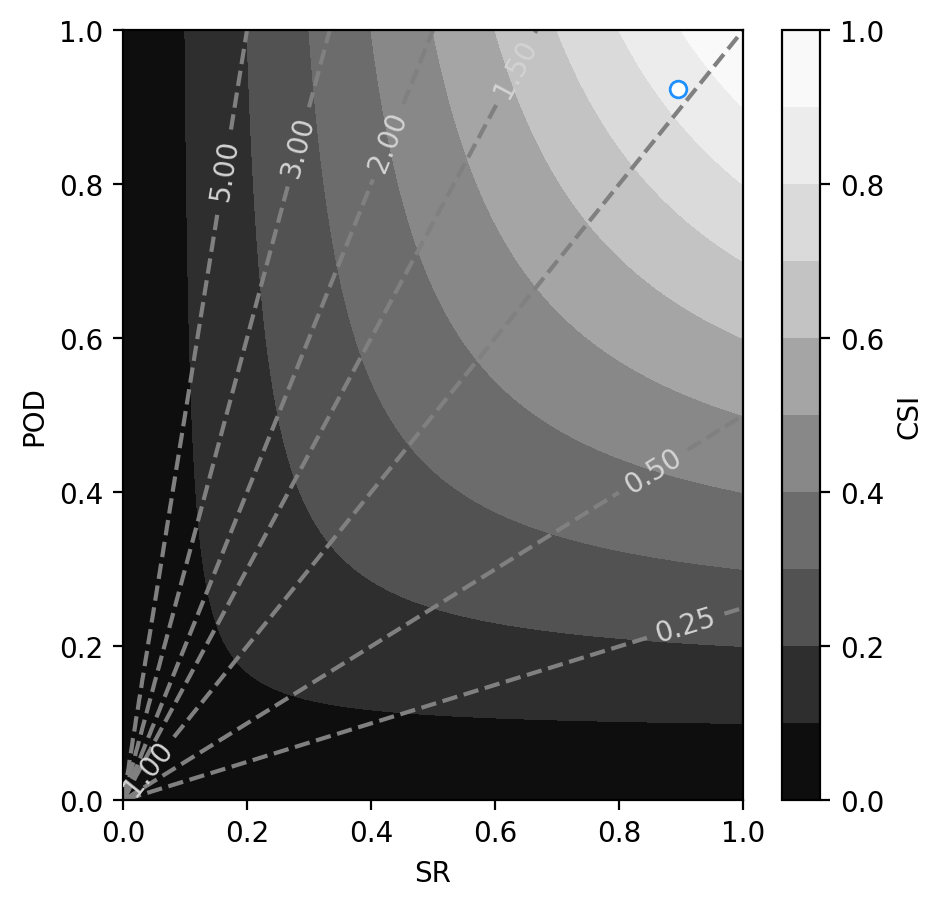

In [8]:
# ユーティリティ関数のインポート
from gewitter_functions import get_pod, get_sr, csi_from_sr_and_pod

# POD、SR、CSIの計算
pod = get_pod(cont_table)
sr = get_sr(cont_table)
csi = csi_from_sr_and_pod(sr, pod)
print(
    "POD:{}, SR:{}, CSI:{}".format(np.round(pod, 2), np.round(sr, 2), np.round(csi, 2))
)

# パフォーマンスダイアグラムにプロット
from gewitter_functions import make_performance_diagram_axis

ax = make_performance_diagram_axis()
ax.plot(sr, pod, "o", color="dodgerblue", markerfacecolor="w")

91%の正解率で CSI は 0.8 以上です。すばらしい結果です。

さて、ML の結果を議論する文献を読んでいるとパフォーマンスダイアグラム上に「線」を描いているのを見ることがあるかもしれません。
例えば、[Lagerquist et al. 2020](https://journals.ametsoc.org/view/journals/mwre/148/7/mwrD190372.xml) の図 5 などです。

これまでのチュートリアルでは `model.predict` の出力を利用してきましたがどんな計算が行われているのかは見えません。
`model.predict` を 1 行実行すると次のような計算が実際には行われます。
`model.predict_proba` メソッドで各データが 雷雲を含む=0 or 含まない=1 に分類される確率を求め、
最も大きな確率をとるクラスをそのデータのクラスとして `model.predict` は出力します。
言い換えれば、分類 0（=雷雲なし）の確率が 0.5 未満であればラベルは 1、0.5 以上であればラベルは 0 になり、
閾値が 0.5 ということです。確率 0.5 ははじめの閾値としては悪くありませんが、閾値を変えることで予測能力が向上する場合もあります。

分類を決めるための閾値を変えることで、図のような「線」が得られます。

同じことを私たちもやってみましょう。まずは `model.predict_proba` の出力を見てみましょう。


In [9]:
yhat_proba = model.predict_proba(X_validate)

print("proba:{},label:{}".format(yhat_proba[0], yhat[0]))

proba:[0.82796707 0.17203293],label:0


0 番目のデータは発雷なしと予測される確率が 90%でありと予測される確率は 10%です。
したがって、閾値を 50%とした場合（`model.predict()` の設定）の予測は 0=発雷なし になります。
しかし、もし閾値を 95%にしたら予測は 1=発雷あり になります。

つまり、ダイアグラム上に「線」をプロットするには閾値を 0 から 1 の間で少しずつ変えていき、
それぞれの閾値について分割表を作成し POD と SR を求めた結果が「線」になります。

コードを書いてみましょう。


In [10]:
import tqdm  # ループの進行具合を表示するためのパッケージ（予測の計算には使わない）

# 分類1をとる閾値について考える
y_preds = yhat_proba[:, 1]

# 0%から100%まで51分割して閾値を動かす
threshs = np.linspace(0, 1, 51, endpoint=True)

# ゼロで初期化する
pods = np.zeros(len(threshs))  # POD
srs = np.zeros(len(threshs))  # SR
csis = np.zeros(len(threshs))  # CSI

for i, t in enumerate(tqdm.tqdm(threshs)):
    # 格納用の配列（分類は0で初期化）
    y_preds_bi = np.zeros(y_preds.shape, dtype=int)

    # 分類1となる確率が閾値を超えているデータのインデックス
    idx = np.where(y_preds >= t)
    # ラベルを1にする
    y_preds_bi[idx] = 1
    # 分割表を求める
    table = get_contingency_table(y_preds_bi, y_validate)
    # POD、SR、CSIを計算
    pods[i] = get_pod(table)
    srs[i] = get_sr(table)
    csis[i] = csi_from_sr_and_pod(sr, pod)

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:00<00:00, 3891.39it/s]


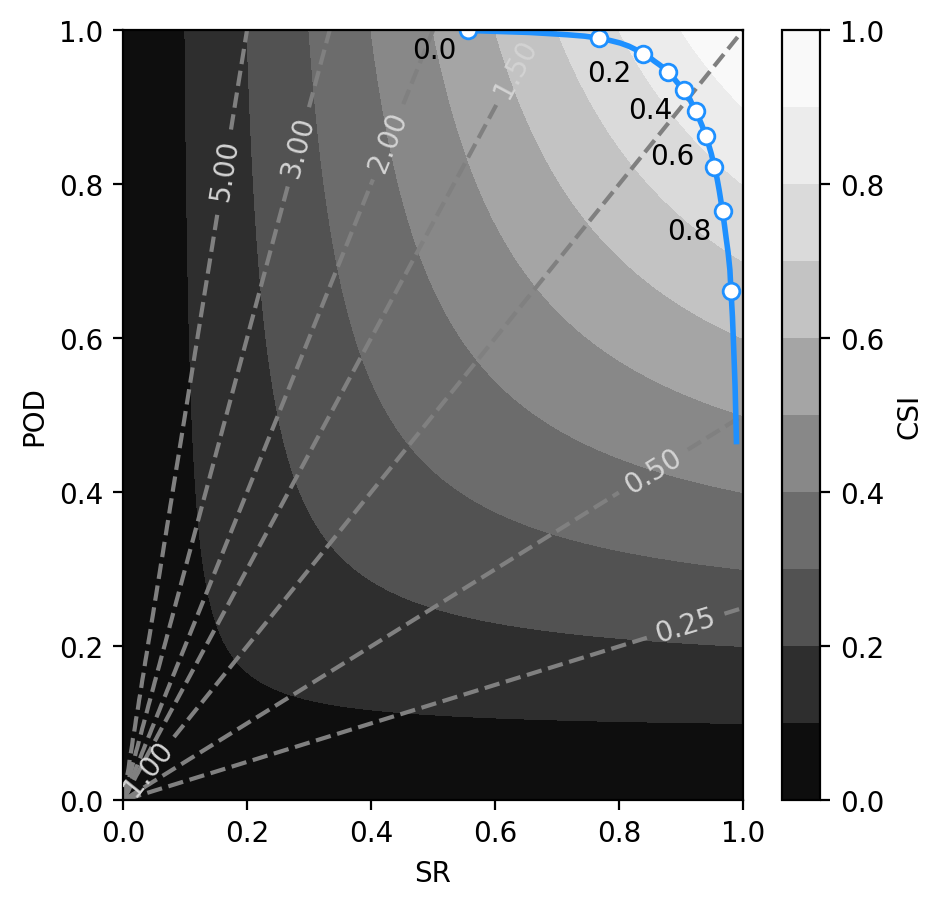

In [11]:
ax = make_performance_diagram_axis()
# 閾値を変えた場合の変化をプロット
ax.plot(srs, pods, "-", color="dodgerblue", lw=2)
# 10%刻みで閾値をプロット
ax.plot(srs[::5], pods[::5], "o", color="dodgerblue", markerfacecolor="w")
for i, (x, y) in enumerate(zip(srs[::10], pods[::10])):
    ax.annotate(
        f"{threshs[::10][i]:.1f}",
        (x, y),
        xytext=(-20, -10),
        textcoords="offset points",
    )

これでダイアグラム上の「線」がどのように求めたものか分かりました。この「線」を求めた目的は何でしょうか？
学習した Ml モデルがバイアスを持つ場合がよくあります。ダイアグラム上の左上、右下ほどバイアスがあることを示します。
閾値の変化を見ることはモデルの学習を調整せずに予測能力を向上させる一つの方法です。
閾値の確率を 0.5 以外の値に変えることでよりよい結果が得られることがこの「線」からわかります。


#### ROC 曲線と AUC

パフォーマンスダイアグラムに閾値を変化させながら「線」を描いたのと同じやり方を使ったダイアグラムと指標として ROC 曲線と AUC と呼ばれるものがあります。
ROC 曲線は y 軸に的中率（POD）、

$$ POD=\frac{TP}{TP+FN}$$

x 軸に誤検出率（POFD）、

$$ POFD =\frac{FP}{FP+TN} $$

をとってプロットしたものです。

AUC は ROC 曲線のが囲む面積で積分により求めます。ユーティリティ関数を使って必要な指標を計算しダイアグラムを描いてみましょう。


In [12]:
from gewitter_functions import get_points_in_roc_curve, get_area_under_roc_curve

# クラス1（発雷あり）について計算
y_preds = yhat_proba[:, 1]

pofds, pods = get_points_in_roc_curve(
    forecast_probabilities=y_preds,
    observed_labels=y_validate,
    threshold_arg=np.linspace(0, 1, 100),
)

Text(0.75, 0.02, 'AUC: 0.97')

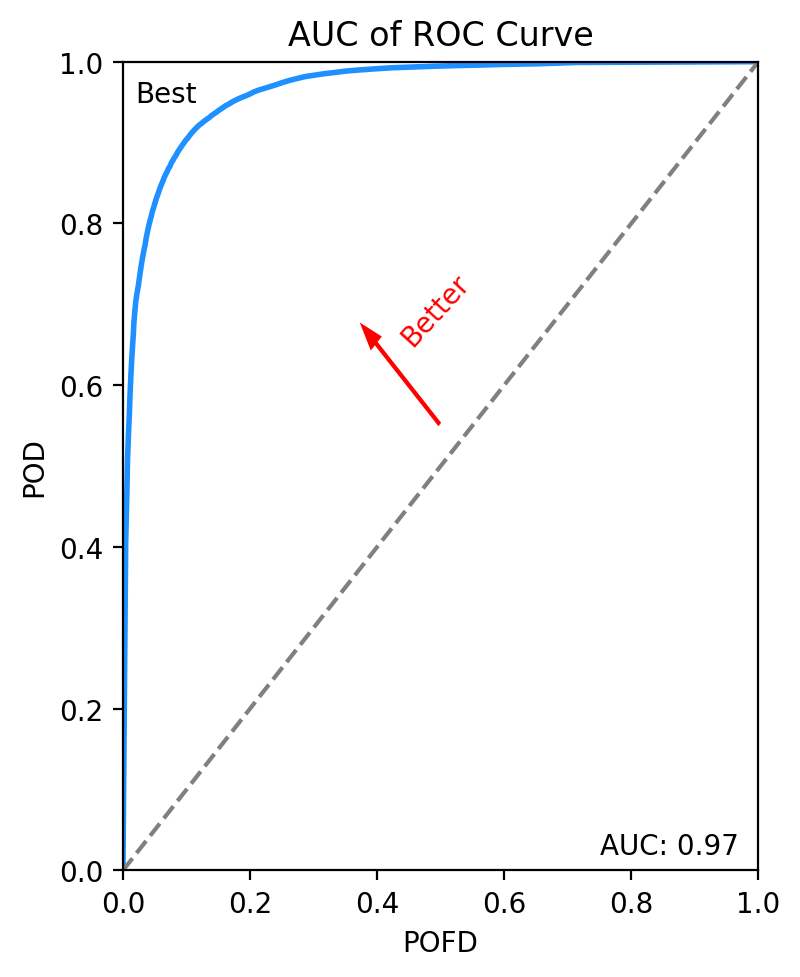

In [13]:
fig, ax = plt.subplots(figsize=(4.1, 5))

# ROC曲線
ax.plot(pofds, pods, color="dodgerblue", markerfacecolor="w", lw=2)

# アノテーション文字列
ax.arrow(0.5, 0.55, -0.1, 0.1, facecolor="r", zorder=5, width=0.01, edgecolor="w")
ax.text(0.43, 0.65, "Better", rotation=47.5, color="r")
ax.text(0.02, 0.95, "Best", color="k", zorder=5)

# 軸範囲の設定
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# スキルなしを表す点線
ax.plot([0, 1], [0, 1], "--", color="Grey")

ax.set_title("AUC of ROC Curve")
ax.set_xlabel("POFD")
ax.set_ylabel("POD")

fig.tight_layout()

ax.text(
    0.75, 0.02, "AUC: {}".format(np.round(get_area_under_roc_curve(pofds, pods), 2))
)

完全予測モデルでは AUC は 1 になります。このモデルは AUC が 0.97 であり非常によい性能であるといえます。
ROC 曲線が左上の枠線に沿っているほどモデルの性能はよいことを表します。ダイアグラムの対角線（点線）に沿った AUC の場合はスキルのない予測（AUC は 0.5）であると判断されます。
